epoch: 100, 对'time traveller'的预测:time traveller ous ind and aly uthe the proust n ans himentilb s
epoch: 200, 对'time traveller'的预测:time traveller allexpestounding a mol sas and why coule as of mh
epoch: 300, 对'time traveller'的预测:time traveller pat of has on soid ficbyers and there whace mave 
epoch: 400, 对'time traveller'的预测:time traveller breced bed and her alwey the prent wo lack to ver
epoch: 500, 对'time traveller'的预测:time traveller smiled lyourd the paysexistions of space he have 
困惑度1.26, 735410.8词元/秒 在cuda:0上
对prefix为'time traveller'的预测:time traveller smiled lyourd the paysexistions of space he have 
对prefix为'traveller'的预测:traveller held and to igee then to mang alonttenetantyourd 


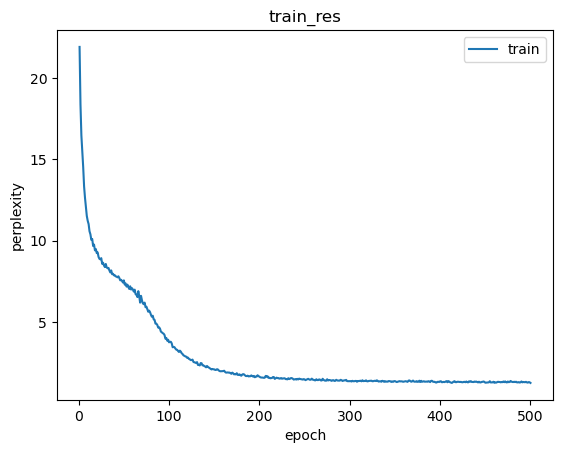

In [3]:
import torch, utils
from torch import nn
from torch.nn import functional as F

# Pytorch API实现的RNN
class RNN(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.rnn_layer = nn.RNN(len(vocab), num_hiddens) # rnn_layer的"输出"(H)不涉及输出层的计算：它是指每个时间步的隐状态，这些隐状态可以用作后续输出层的输入
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn_layer.hidden_size
        if not self.rnn_layer.bidirectional: # 如果RNN不是双向的,num_directions应该是1
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else: # 如果RNN是双向的,num_directions应该是2
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

    def forward(self, inputs, state):
        """
        参数:\n
        inputs: 批量矩阵X转置后的独热编码,形状为(时间步数量, 批量大小, 词表大小), 每一行是批量矩阵中各个样本在某一时间步的特征\n
        state: 上一时间步的隐状态，张量变量，形状为(批量大小,隐藏单元数)
        返回:\n
        形状为(num_steps*batch_size, num_outputs)的预测序列 和 隐状态
        """
        X = F.one_hot(inputs.T.long(), self.vocab_size).to(torch.float32) # 将输入转成one-hot向量表示 shape=(num_steps, batch_size, vocab_size)
        H, state = self.rnn_layer(X, state) # H.shape=(num_steps, batch_size, num_hiddens)
        output = self.linear(H.reshape((-1, H.shape[-1]))) # 全连接层首先将H的形状改为(时间步数*批量大小,隐藏单元数),它的输出形状是(时间步数*批量大小,词表大小)。
        return output, state
    
    def begin_state(self, device, batch_size=1):
        """
        返回隐藏层的初始状态\n
        参数:\n
        batch_size : 批量大小\n
        返回:\n
        若隐藏层是nn.GRU,返回形状为(num_layers * num_directions, batch_size, hidden_size)的全0张量隐状态\n
        若隐藏层是nn.LSTM,返回形状为(2, num_layers * num_directions, batch_size, hidden_size)的全0张量隐状态
        """
        if not isinstance(self.rnn_layer, nn.LSTM): # nn.GRU以张量作为隐状态
            return torch.zeros(size=(self.num_directions * self.rnn_layer.num_layers, batch_size, self.num_hiddens),
                                device=device)
        else: # nn.LSTM以元组作为隐状态
            return (torch.zeros(size=(self.num_directions * self.rnn_layer.num_layers, batch_size, self.num_hiddens),
                                device=device),
                    torch.zeros(size=(self.num_directions * self.rnn_layer.num_layers, batch_size, self.num_hiddens),
                                device=device))

batch_size, num_steps = 32, 35
num_epochs, lr = 500, 1
num_hiddens = 256
device = utils.try_gpu()
train_iter, vocab = utils.load_time_machine_data(batch_size, num_steps)
net = RNN(vocab_size=len(vocab)).to(device)
utils.rnn_train(net, train_iter, vocab, lr, num_epochs, device)